In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import zipfile as zf
files=zf.ZipFile("/content/drive/MyDrive/vgg16 Dataset/Dataset_vgg.zip","r")
files.extractall("VGG16")
files.close()

In [15]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [16]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
rm -rf "VGG16/val"

In [18]:
import splitfolders
splitfolders.ratio("VGG16", output="output", seed=1337, ratio=(0.8, 0.2,0))

Copying files: 1412 files [00:00, 3103.72 files/s]


In [19]:
# loading the directories 
training_dir = '/content/output/train'
validation_dir = '/content/output/val'
test_dir = '/content/output/test'

In [20]:
# useful for getting number of files
image_files = glob(training_dir + '/*/*.jp*g')
valid_image_files = glob(validation_dir + '/*/*.jp*g')

In [21]:
# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 4


In [22]:
# this will copy the pretrained weights to our kernel
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

mkdir: cannot create directory ‘/root/.keras’: File exists
cp: cannot stat '../input/keras-pretrained-models/*notop*': No such file or directory
cp: cannot stat '../input/keras-pretrained-models/imagenet_class_index.json': No such file or directory


In [23]:
# importing the libraries
from keras.models import Model
from keras.layers import Flatten, Dense
from keras import applications
#from keras.applications import VGG16
from tensorflow.keras.applications import  VGG16
#from keras.preprocessing import image

IMAGE_SIZE = [64, 64]  # we will keep the image size as (64,64). You can increase the size for better results. 

# loading the weights of VGG16 without the top layer. These weights are trained on Imagenet dataset.
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# this will exclude the initial layers from training phase as there are already been trained.
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
#x = Dense(128, activation = 'relu')(x)   # we can add a new fully connected layer but it will increase the execution time.
x = Dense(num_classes, activation = 'softmax')(x)  # adding the output layer with softmax function as this is a multi label classification problem.

model = Model(inputs = vgg.input, outputs = x)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58889256/58889256 [==============================] - 3s 0us/step


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [25]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [26]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max' )

In [27]:
# Image Augmentation

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 32, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 32, class_mode = 'categorical')

Found 1128 images belonging to 4 classes.
Found 280 images belonging to 4 classes.


In [28]:
# The labels are stored in class_indices in dictionary form. 
# checking the labels
training_generator.class_indices

{'apple': 0, 'banana': 1, 'rotten_apple': 2, 'rotten_banana': 3}

In [30]:
history = model.fit(training_generator,
                   steps_per_epoch = int(808/32), #len(training_dir),  # this should be equal to total number of images in training set. But to speed up the execution, I am only using 10000 images. Change this for better results. 
                   epochs = 40,  # change this for better results
                   validation_data = validation_generator,
                   validation_steps = int(200/32)) #len(validation_dir))  # this should be equal to total number of images in validation set.
                   

Epoch 1/40
25/25 [==============================] - 15s 604ms/step - loss: 0.0474 - accuracy: 0.9950 - val_loss: 0.0818 - val_accuracy: 0.9740
Epoch 2/40
25/25 [==============================] - 13s 550ms/step - loss: 0.0396 - accuracy: 0.9937 - val_loss: 0.0486 - val_accuracy: 0.9948
Epoch 3/40
25/25 [==============================] - 14s 573ms/step - loss: 0.0394 - accuracy: 0.9923 - val_loss: 0.0715 - val_accuracy: 0.9844
Epoch 4/40
25/25 [==============================] - 13s 533ms/step - loss: 0.0430 - accuracy: 0.9910 - val_loss: 0.0689 - val_accuracy: 0.9896
Epoch 5/40
25/25 [==============================] - 15s 633ms/step - loss: 0.0436 - accuracy: 0.9950 - val_loss: 0.0631 - val_accuracy: 0.9896
Epoch 6/40
25/25 [==============================] - 13s 527ms/step - loss: 0.0371 - accuracy: 0.9961 - val_loss: 0.0630 - val_accuracy: 0.9844
Epoch 7/40
25/25 [==============================] - 13s 536ms/step - loss: 0.0532 - accuracy: 0.9845 - val_loss: 0.0786 - val_accuracy: 0.9792

In [31]:
print ('Training Accuracy = ' + str(history.history['accuracy']))
print ('Validation Accuracy = ' + str(history.history['val_accuracy']))


Training Accuracy = [0.9950000047683716, 0.9937499761581421, 0.9922680258750916, 0.9909793734550476, 0.9950000047683716, 0.9961340427398682, 0.9845361113548279, 0.9909793734550476, 0.9909793734550476, 0.9948453903198242, 0.9887499809265137, 0.9950000047683716, 0.998711347579956, 0.9937499761581421, 0.9961340427398682, 0.9974226951599121, 0.9975000023841858, 0.9909793734550476, 0.9950000047683716, 0.9948453903198242, 0.9974226951599121, 0.998711347579956, 0.9975000023841858, 0.998711347579956, 0.9887499809265137, 0.9935566782951355, 1.0, 0.9948453903198242, 0.998711347579956, 0.9909793734550476, 0.9961340427398682, 0.9950000047683716, 0.9962499737739563, 0.9961340427398682, 0.9935566782951355, 0.9974226951599121, 0.9948453903198242, 0.9937499761581421, 1.0, 0.9975000023841858]
Validation Accuracy = [0.9739583134651184, 0.9947916865348816, 0.984375, 0.9895833134651184, 0.9895833134651184, 0.984375, 0.9791666865348816, 0.984375, 0.9895833134651184, 0.9739583134651184, 0.984375, 0.984375, 

In [32]:
hist= history.history

Text(0, 0.5, 'accuracy')

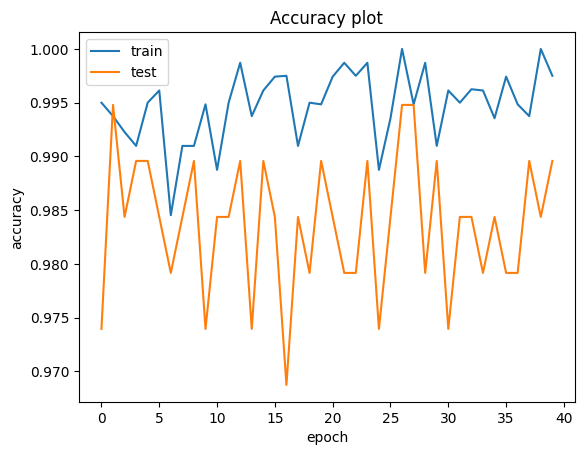

In [33]:
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Accuracy plot")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("accuracy")

Text(0, 0.5, 'loss')

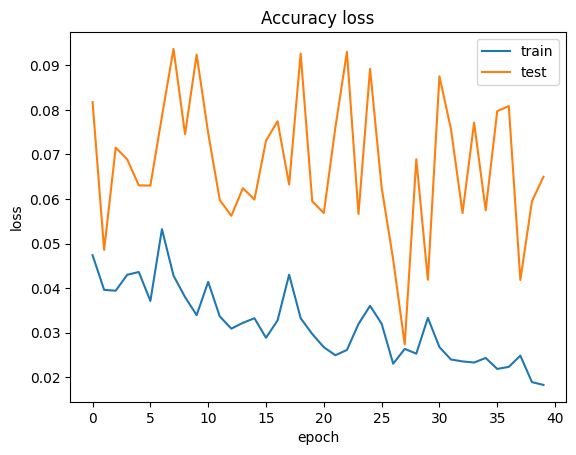

In [34]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Accuracy loss")
plt.legend(["train","test"])
plt.xlabel("epoch")
plt.ylabel("loss")

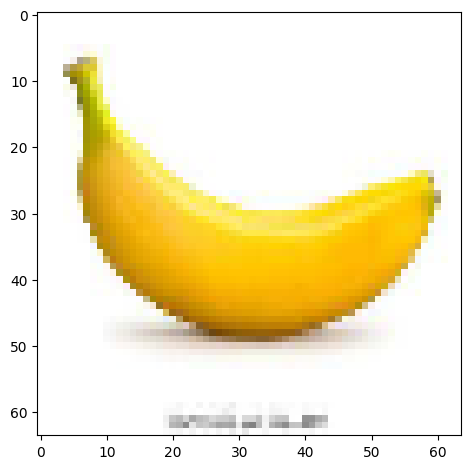

In [41]:
import cv2
from matplotlib import pyplot as plt
from skimage import io

image = io.imread("/content/download.jpg")
image_resized= cv2.resize(image,(64, 64))
image=np.expand_dims(image_resized,axis=0)

io.imshow(image_resized)
plt.show()

In [42]:
pred=model.predict(image)

output_class=[np.argmax(pred)]
print("The predicted class is", output_class)

1/1 [==============================] - 0s 20ms/step
The predicted class is [1]
